# Predicting Pharmaceutical Drug Sales in South Korea
From the initial EDA, we discussed the relationships between several features and gas generation in South Korea. However, while exploring those features, we found that some aspects (especially infectious disease and pharmaceutical sales) didn't really have significant connections to gas generation. Therefore, we will instead explore a pivoted idea, instead prediction the total pharmaceutical drug sales using the afformentioned features. 

A condensed feature correlation plot is shown below to summarize the relationships we found with the different explored features. Further information can be found in the initial EDA notebook: https://github.com/kevinjin21/SpringboardProjects/blob/main/Capstone/Korea%20Gas%20and%20Electricity%20Comprehensive%20EDA.ipynb

<div>
<img src="Data/feature_correlation_all.png" width=1000/>
</div>

## Import data and dependencies
EDIT: Later on in the modeling, we run into some variance based on stochastic nature of some parts of modeling. This is not abnormal, but for reproducibility's sake, we will set a random seed from the beginning of the notebook for _numpy_ and
_random_.

In [1]:
# Extensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import date
%matplotlib inline

In [2]:
# Modeling 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

### Set seed values

In [3]:
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)

### Explore data

In [23]:
# Pharmaceutical dataset - all features
df = pd.read_excel('Data/Korea_Data_All.xlsx', sheet_name='PHARM_ALL')
df

,Year,Month,Total Sales,Seoul_1,Seoul_2,Seoul_3,Seoul_4,Total_Surgeries,Seoul_Accidents,Seoul_Deaths,...,Seoul_Gas,Seoul_Temp,Seoul_O3,Seoul_SO3,Seoul_NO2,Seoul_CO,Gyeonggi_PM10,Seoul Total Precipitation (mm),Seoul Mean Wind Speed (m/s),Seoul Mean Rel. Humid. (%)
0,2008,1,356295,69.0,2620.0,9594.0,8.0,155338,2607,38,...,822116.0,-1.7,0.011889,0.007667,0.039222,0.755556,61.666667,17.7,2.3,50
1,2008,2,356295,NaN,NaN,NaN,NaN,125656,2562,32,...,806820.0,-1.2,0.014111,0.006556,0.042111,0.788889,69.555556,15.0,2.7,46
2,2008,3,356295,NaN,NaN,NaN,NaN,135139,3189,44,...,611034.0,7.3,0.025000,0.005000,0.031000,0.500000,69.777778,53.9,2.6,56
3,2008,4,356295,NaN,NaN,NaN,NaN,125437,3399,44,...,397143.0,14.1,0.026889,0.004556,0.035333,0.500000,62.000000,38.5,2.7,50
4,2008,5,356295,NaN,NaN,NaN,NaN,123598,3838,36,...,246734.0,17.7,0.029556,0.005111,0.034444,0.500000,71.888889,97.7,2.7,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021,8,670686,NaN,NaN,NaN,NaN,161749,2778,25,...,NaN,NaN,0.034000,0.003000,0.015000,0.400000,25.000000,211.2,2.1,74
164,2021,9,670686,NaN,NaN,NaN,NaN,154439,2737,24,...,NaN,NaN,0.031000,0.003000,0.014000,0.400000,17.000000,131.0,2.3,71
165,2021,10,670686,NaN,NaN,NaN,NaN,174234,2814,24,...,NaN,NaN,0.022000,0.003000,0.022000,0.400000,31.000000,57.0,2.1,70
166,2021,11,670686,NaN,NaN,NaN,NaN,181995,2925,19,...,NaN,NaN,0.018000,0.003000,0.031000,0.600000,48.000000,62.4,2.1,68


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              168 non-null    int64  
 1   Month                             168 non-null    int64  
 2   Total Sales                       168 non-null    int64  
 3   Seoul_1                           12 non-null     float64
 4   Seoul_2                           12 non-null     float64
 5   Seoul_3                           12 non-null     float64
 6   Seoul_4                           12 non-null     float64
 7   Total_Surgeries                   168 non-null    int64  
 8   Seoul_Accidents                   168 non-null    int64  
 9   Seoul_Deaths                      168 non-null    int64  
 10  Seoul_Injured                     168 non-null    int64  
 11  International flight (passenger)  156 non-null    float64
 12  Domestic

## Clean the dataset

Above, we can see the different feature names, and as observed in the full 'df' dataframe, there are quite a bit of missing values. These come from two main sources:

1. The total sales data ranges from Jan 2008 to Dec 2021. Some datasets don't go all the way to the end of 2021, so we'll remove the trailing data, instead ending at the end of 2019.
2. Some data are annual, meaning they only have one entry per year. We will use forward fill (ffill) to create a stepwise monthly value for these data. (Note: This was also done for the pharmaceutical data)

### 1. Trailing Data removal

The Seoul1-4 (infectious disease) data only has 12 values, representing 12 years worth of data. This means the dataset should end at 2019 instead of 2021, as it starts in 2008. We will remove the extra rows.

In [24]:
df = df[df.Year < 2020]
df.tail(12)

,Year,Month,Total Sales,Seoul_1,Seoul_2,Seoul_3,Seoul_4,Total_Surgeries,Seoul_Accidents,Seoul_Deaths,...,Seoul_Gas,Seoul_Temp,Seoul_O3,Seoul_SO3,Seoul_NO2,Seoul_CO,Gyeonggi_PM10,Seoul Total Precipitation (mm),Seoul Mean Wind Speed (m/s),Seoul Mean Rel. Humid. (%)
132,2019,1,599303,3251.0,12115.0,12544.0,107.0,199086,2983,25,...,754822.0,-0.9,0.012,0.005,0.039,0.8,72.0,0.0,1.8,46
133,2019,2,599303,NaN,NaN,NaN,NaN,157978,2482,13,...,662117.0,1.0,0.018,0.005,0.036,0.7,61.0,23.8,1.8,47
134,2019,3,599303,NaN,NaN,NaN,NaN,176493,3099,22,...,479716.0,7.1,0.028,0.005,0.034,0.6,72.0,26.8,2.1,51
135,2019,4,599303,NaN,NaN,NaN,NaN,174041,3283,14,...,371517.0,12.1,0.029,0.004,0.029,0.5,45.0,47.3,1.9,51
136,2019,5,599303,NaN,NaN,NaN,NaN,170519,3497,24,...,227515.0,19.4,0.043,0.005,0.028,0.5,56.0,37.8,2.1,47
137,2019,6,599303,NaN,NaN,NaN,NaN,151257,3290,20,...,172980.0,22.5,0.039,0.004,0.020,0.4,32.0,74.0,1.7,61
138,2019,7,599303,NaN,NaN,NaN,NaN,168460,3311,15,...,172649.0,25.9,0.031,0.004,0.018,0.4,30.0,194.4,1.8,69
139,2019,8,599303,NaN,NaN,NaN,NaN,151009,3447,22,...,160321.0,27.2,0.030,0.004,0.018,0.4,29.0,190.5,1.6,69
140,2019,9,599303,NaN,NaN,NaN,NaN,147525,3313,25,...,155577.0,22.6,0.024,0.003,0.021,0.4,26.0,139.8,2.2,65
141,2019,10,599303,NaN,NaN,NaN,NaN,162983,3634,31,...,185075.0,16.4,0.021,0.003,0.025,0.5,37.0,55.5,2.1,62


### 2. Forward fill annual data
As mentioned above, some data are annual in nature. We will forward fill the values to create stepwise monthly data.

In [25]:
df = df.fillna(method='ffill')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              144 non-null    int64  
 1   Month                             144 non-null    int64  
 2   Total Sales                       144 non-null    int64  
 3   Seoul_1                           144 non-null    float64
 4   Seoul_2                           144 non-null    float64
 5   Seoul_3                           144 non-null    float64
 6   Seoul_4                           144 non-null    float64
 7   Total_Surgeries                   144 non-null    int64  
 8   Seoul_Accidents                   144 non-null    int64  
 9   Seoul_Deaths                      144 non-null    int64  
 10  Seoul_Injured                     144 non-null    int64  
 11  International flight (passenger)  144 non-null    float64
 12  Domestic

Everything is now uniform across the board, with the same number of values per feature and over the same time period. Let's get to initial modeling.

# Modeling
We have many features in this dataset. We'll first try modeling with *all features included* to see initially how the model can perform, and to provide a baseline standard for the predictive value of this model. 

<u>Target</u>: Annual Pharmaceutical Total Sales in Korea (year 2008-2019)
<br><u>Features</u>: Infectious Disease (Type 1-4), Total Surgeries, Accidents and Injuries/Deaths, International and Domestic flights, Total Constructed Buildings, Buildings Constructed with Certain Materials, Buildings Constructed for Certain Purposes, Total Fires, Gas and Electricity Generation, Temperature, Pollutant Data, and Weather Data.

The model we will try is a Random Forest, as it proved to perform the best in our initial modeling (Check the 'Modeling' notebook). Later on we may experiment with other models as well.

## Random Forest - Untuned, all features
Let's train a simple random forest to act as a baseline for the predictive strength of our features.

### Normalize Data
It is visible above, but the data we are dealing with is highly irregular in scale across the different features. We'll normalize it with a normalizing function before splitting the data or modeling. The features and target will then all be ranging from 0-1.

In [26]:
# Using our normalizing function from before:
def normalize(df):
    for column in df.columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min()) 
    return df

In [27]:
norm_df = normalize(df)
norm_df.describe()

,Year,Month,Total Sales,Seoul_1,Seoul_2,Seoul_3,Seoul_4,Total_Surgeries,Seoul_Accidents,Seoul_Deaths,...,Seoul_Gas,Seoul_Temp,Seoul_O3,Seoul_SO3,Seoul_NO2,Seoul_CO,Gyeonggi_PM10,Seoul Total Precipitation (mm),Seoul Mean Wind Speed (m/s),Seoul Mean Rel. Humid. (%)
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,0.500000,0.500000,0.473135,0.202291,0.407831,0.441628,0.093264,0.390818,0.553553,0.485764,...,0.309253,0.557793,0.388185,0.329604,0.483796,0.265432,0.445879,0.098576,0.489418,0.456790
std,0.314918,0.314918,0.291292,0.267137,0.334690,0.305593,0.276129,0.181320,0.195599,0.202964,...,0.294597,0.285951,0.259847,0.192283,0.212419,0.257265,0.224355,0.144238,0.204561,0.225232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.298517,0.055399,0.144293,0.151381,0.000300,0.262281,0.462645,0.350000,...,0.046324,0.295139,0.147059,0.166667,0.300000,0.000000,0.246094,0.022834,0.333333,0.305556
50%,0.500000,0.500000,0.423679,0.092593,0.387729,0.414196,0.000603,0.370552,0.573791,0.475000,...,0.208260,0.591667,0.367647,0.333333,0.566667,0.200000,0.460938,0.049381,0.476190,0.416667
75%,0.750000,0.750000,0.688904,0.272207,0.587542,0.664690,0.001003,0.505527,0.678659,0.625000,...,0.582352,0.822222,0.588235,0.500000,0.624074,0.400000,0.609375,0.110433,0.619048,0.583333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Define features and target
Note: We drop 'Year' and 'Month', as they act more as indices than modeling features.

In [28]:
target = norm_df['Total Sales']
features = norm_df.drop(columns=['Year', 'Month', 'Total Sales'])

### Split into training and test data
To properly train and test our model, we'll split the data into train and test sets, with a 70/30 ratio of training to test data. To do this, we use TrainTestSplit.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=seed_value)

### First try with Random Forest Regressor

In [12]:
# initialize regressor
forest = RandomForestRegressor(random_state=seed_value)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

To benchmark our results, we'll again view the mean squared error (MSE) and root mean squared error (RMSE) of each model. This can be done using scikit-learn's mean_squared_error.

In [13]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Untuned, All Feature Random Forest): ', mse)
print('RMSE (Untuned, All Feature Random Forest): ', rmse)

MSE (Untuned, All Feature Random Forest):  8.992758209904957e-05
RMSE (Untuned, All Feature Random Forest):  0.009483015453907558


We can see here that the MSE is already in the scale of __1e-5__! This shows strong predictive strength with our many features. However, they are not necessarily all beneficial to the model. Let's see how we can narrow things down by _removing features and tuning_.

### 1. Check correlation plot for extreme features
Our intial error is very low. There is potential for a not-entirely-independent feature in the data, causing this very accurate data. If this exists, it is interesting to know what causes this interaction, and if there is any conclusion to reach. Also, it may be more meaningful to remove this feature (due to the non-independent nature of the data).

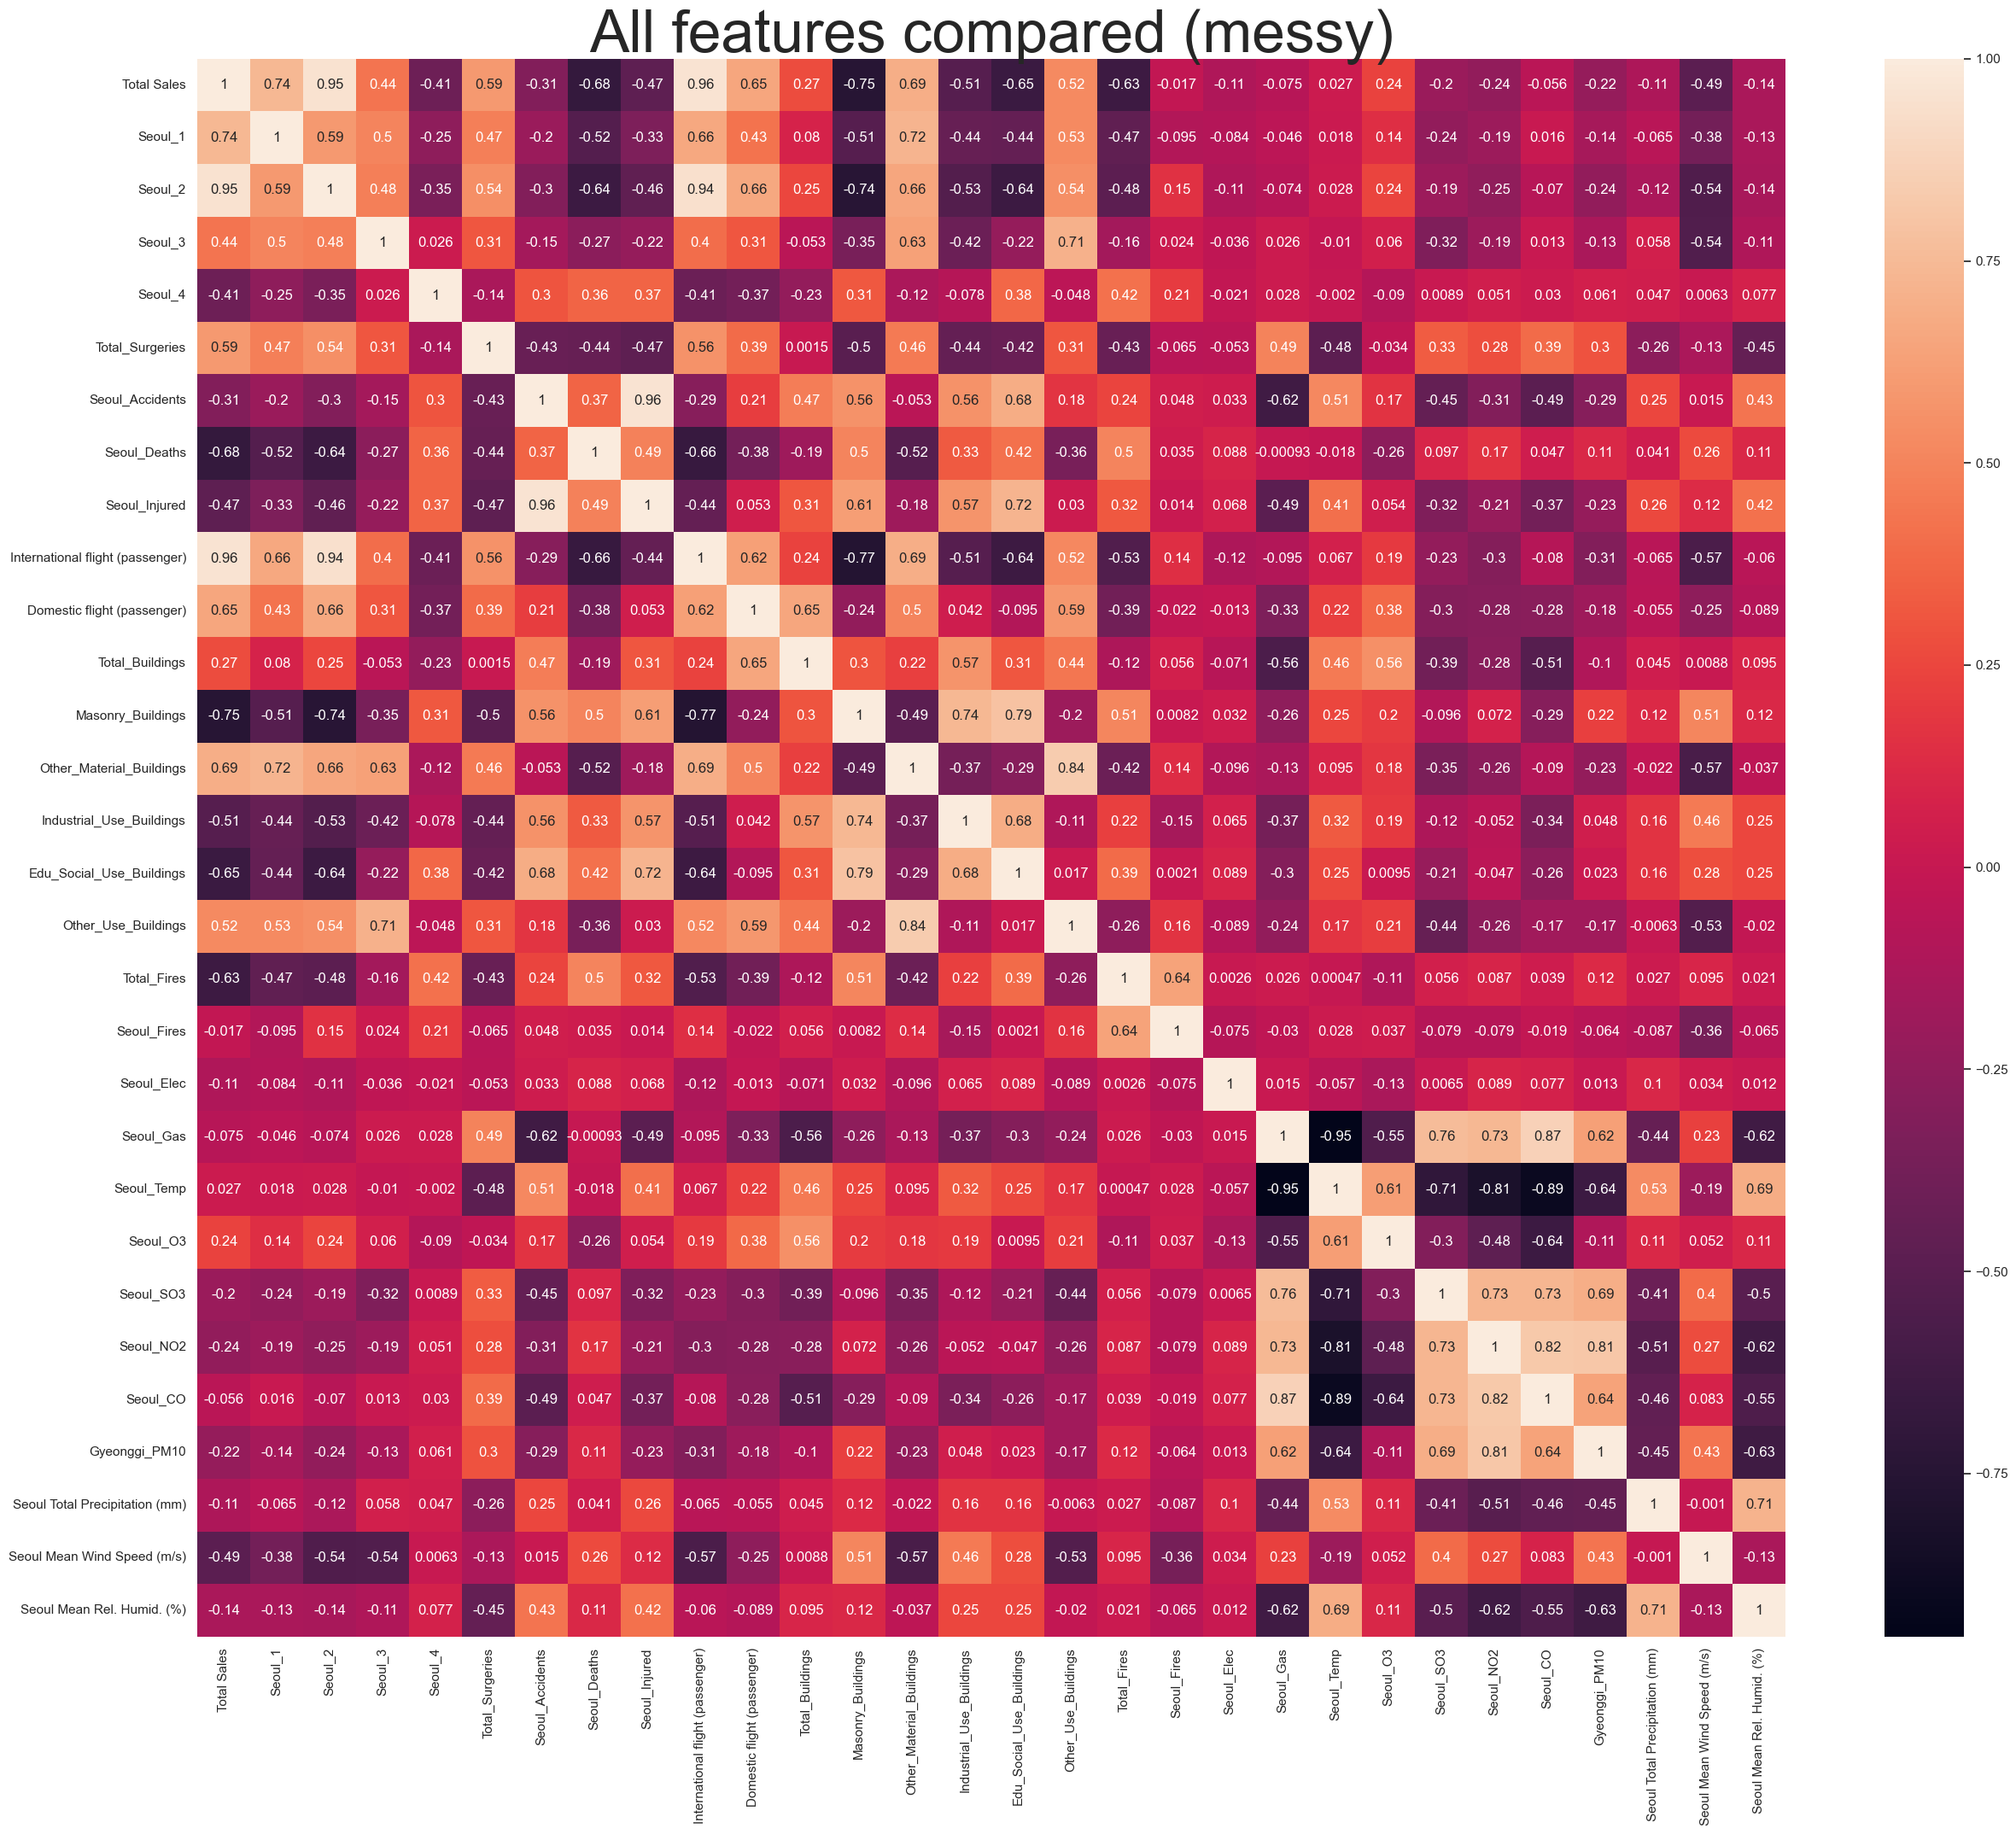

In [22]:
sns.set(rc={'figure.figsize':(30,24)})
plt.title('All features compared (messy)', size=50)
sns.heatmap(norm_df.drop(columns=['Year','Month']).corr(), annot=True);

### 2. Closer look at highly correlated features

It's a little hard to see, but there are actually some interesting feature correlations here! We'll filter out correlations less than abs(0.75), which can be considered strongly correlated. 

Pay special attention to the relationship between __Seoul infectious disease category 2 and International passenger flight__ when compared to total sales. It is interesting to see the strong relationship there! Let's take a closer look:

In [122]:
# define correlation plot (remove Year and Month, as they are not features)
strong_corr = norm_df.drop(columns=['Year', 'Month']).corr()

# separate upper triangle
upper = strong_corr.where(np.triu(np.ones(strong_corr.shape), k=1).astype(np.bool))

In [137]:
# drop correlations that are under 0.75 which we can consider strongly correlated
to_keep = [column for column in upper.columns if any(np.abs(upper[column]) >= 0.75)]

# this drops total sales, so we should add it back in (as it's the target after all)
to_keep.insert(0, 'Total Sales')

# final df with only highly correlated features (>0.75)
dropped_df = norm_df.loc[:, to_keep]

This will still keep correlations under 0.75 because not all features will have strong correlations with each other. We'll filter these out by just setting lower values to 0 for easier visibility.

In [138]:
# set lower correlations to 0
dropped_corr = dropped_df.corr()
dropped_corr[np.abs(dropped_corr)<0.75] = 0

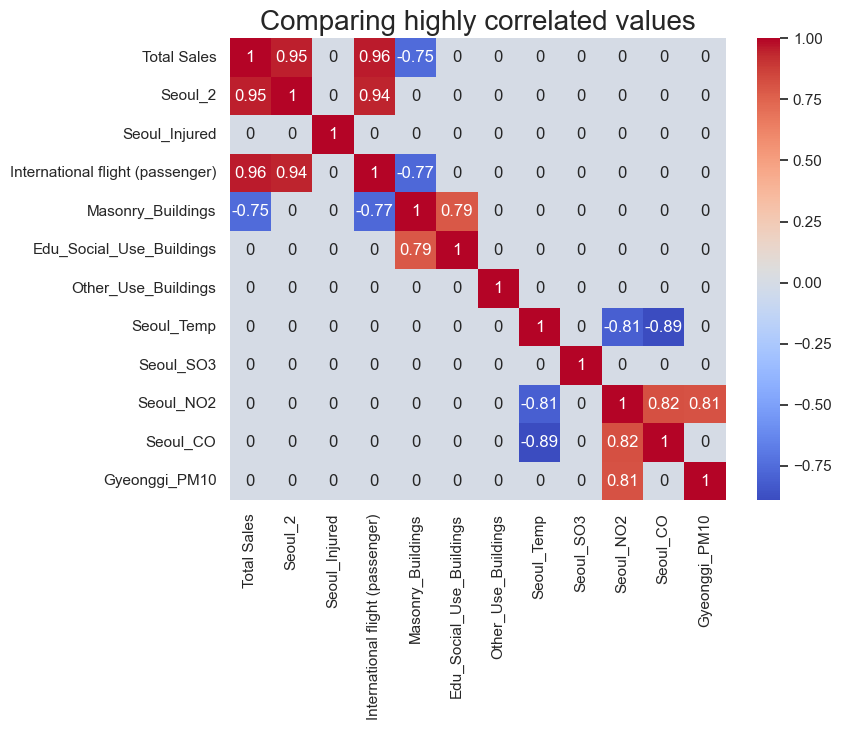

In [140]:
sns.set(rc={'figure.figsize':(8,6)})
plt.title('Comparing highly correlated values', size=20)
sns.heatmap(dropped_corr, annot=True, cmap='coolwarm');

### Interesting takeaway
We can see here that there is a strong relationship between several features. __Most interestingly, total pharmaceutical sales, Seoul infectious disease category 2 (vaccine preventable viral disease like measles and polio), and total international flight passengers have an especially strong relationship (>0.9)__. The connection is not innately obvious, so it is interesting to observe this highly correlated behavior in the features!

There are some other notable correlations, such as Seoul_Temp, Seoul_NO2, and Seoul_CO. Our focus is on Total Sales, as it is our target in this project, but these relationships are intriguing nonetheless.

## Recursive Feature Elimination 1
Now that we've seen how the model performs with all features and have documented some interesting connections found in the data, let's see how we can improve it by potentially removing some less relevant features. 

This will be done in similar fashion to the recursive modeling in the Gas Generation modeling notebook: by using RFECV. 

### Import additional dependencies 

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std

### Initialize feature eliminator and pipeline

In [142]:
# create pipeline
rfe = RFECV(estimator=RandomForestRegressor())
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed_value)
n_scores = cross_val_score(pipeline, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

In [143]:
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MSE: -0.000 (0.000)


The error from this feature elimination is too low to report already! Let's see what features were chosen.

### Fit to features and target and show results

In [144]:
rfe.fit(features, target)

RFECV(estimator=RandomForestRegressor())

In [145]:
for i in range(features.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 2.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 5.000
Column: 3, Selected False, Rank: 7.000
Column: 4, Selected False, Rank: 10.000
Column: 5, Selected False, Rank: 15.000
Column: 6, Selected False, Rank: 22.000
Column: 7, Selected False, Rank: 11.000
Column: 8, Selected False, Rank: 4.000
Column: 9, Selected False, Rank: 18.000
Column: 10, Selected False, Rank: 26.000
Column: 11, Selected False, Rank: 12.000
Column: 12, Selected False, Rank: 8.000
Column: 13, Selected False, Rank: 27.000
Column: 14, Selected False, Rank: 23.000
Column: 15, Selected False, Rank: 9.000
Column: 16, Selected False, Rank: 3.000
Column: 17, Selected False, Rank: 6.000
Column: 18, Selected False, Rank: 20.000
Column: 19, Selected False, Rank: 16.000
Column: 20, Selected False, Rank: 14.000
Column: 21, Selected False, Rank: 13.000
Column: 22, Selected False, Rank: 25.000
Column: 23, Selected False, Rank: 17.000
Column: 24, Selected False, Rank: 19

Converting this back to our feature names:

In [146]:
features.columns[1]

'Seoul_2'

## First elimination result:
According to the recursive feature elimination, the model would work best by only using the data from Seoul infectious disease category 2! This is a bit expected from the high correlation, but perhaps doesn't make for a good model. 

__It seems that 'Seoul_2' is too closely related to Total Sales__.

Thus, it will make for a more compelling model to remove Seoul_2 from the features. However, it is still interesting to see the potential performance of performing a regression with only Seoul_2 as a single feature. Let's quickly see how it does:

### Aside: Using only Seoul_2 as a feature
A quick aside from the main problem, let's see how the model performs with just the recommended single feature selected.

In [154]:
# re-split and define the test and training data (features should be changed to only use Seoul_2 data)
X_train, X_test, y_train, y_test = train_test_split(features.Seoul_2, target, test_size=0.3, random_state=seed_value)

In [166]:
# initialize regressor
forest = RandomForestRegressor(random_state=seed_value)
forest = forest.fit(X_train.array.reshape(-1, 1), y_train)
y_pred = forest.predict(X_test.array.reshape(-1, 1))

In [167]:
# calculate and present the error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Seoul_2 Random Forest): ', mse)
print('RMSE (Seoul_2 Random Forest): ', rmse)

MSE (Seoul_2 Random Forest):  5.823805244407725e-07
RMSE (Seoul_2 Random Forest):  0.0007631386010684905


### Results from quick aside and small takeaway:
The error is quite small, with MSE in the range of 1e-7. This just shows how strongly dependent the data of Seoul_2 and Total Sales was!

As mentioned before, it is really interesting that these have a connection. However, Seoul_2 is a category of disease that is curable through vaccines. As a result, it is highly likely that __more cases of category 2 type diseases would result in more pharmaceutical drug sales!__

## Feature Elimination: Seoul_2 removed
We will then repeat the previous steps, but with Seoul_2 removed from the feature set and see how everything performs.

First, a plain Random Forest Regressor without Seoul_2:

### Redefine features and training sets

In [30]:
features = features.drop(columns='Seoul_2')

In [31]:
# re-split and define the test and training data (features should be changed remove Seoul_2 data)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=seed_value)

### Test with basic random forest

In [17]:
# initialize regressor
forest = RandomForestRegressor(random_state=seed_value)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [18]:
# calculate and present the error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Seoul_2 Removed Random Forest): ', mse)
print('RMSE (Seoul_2 Removed Random Forest): ', rmse)

MSE (Seoul_2 Removed Random Forest):  0.00044073870603484315
RMSE (Seoul_2 Removed Random Forest):  0.020993777793309215


We can see here that the error is significantly larger without the effects of using Seoul_2 to predict. However, it is still relatively low.

## Recursive Feature Elimination 2

In [172]:
# create pipeline
rfe = RFECV(estimator=RandomForestRegressor())
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed_value)
n_scores = cross_val_score(pipeline, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

In [173]:
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MSE: -0.001 (0.002)


The error is a bit larger this time, as expected.

In [174]:
rfe.fit(features, target)

RFECV(estimator=RandomForestRegressor())

In [175]:
selected = []
for i in range(features.shape[1]):
    if rfe.support_[i]:
        selected.append(i)
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 13.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 10.000
Column: 9, Selected False, Rank: 11.000
Column: 10, Selected False, Rank: 18.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 4.000
Column: 13, Selected False, Rank: 6.000
Column: 14, Selected False, Rank: 5.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 2.000
Column: 18, Selected False, Rank: 7.000
Column: 19, Selected False, Rank: 16.000
Column: 20, Selected False, Rank: 14.000
Column: 21, Selected False, Rank: 12.000
Column: 22, Selected False, Rank: 3.000
Column: 23, Selected False, Rank: 15.000
Column: 24, Selected False, Rank: 17.000
Column: 25,

There are more selected features this time! Let's present it in a more easily understandable way.

In [176]:
print('Selected features: ', *features.iloc[:,selected].columns, sep='\n')

Selected features: 
Seoul_1
Seoul_3
Seoul_4
Total_Surgeries
Seoul_Accidents
Seoul_Injured
International flight (passenger)
Other_Material_Buildings
Total_Fires
Seoul_Fires
Seoul Mean Rel. Humid. (%)


In [177]:
print(len(selected))

11


## Second Elimination Result:
Without the overpowering effect of Seoul_2, we have quite a few other features that are deemed fit to use for modeling. 

In this case, 11 out of the 29 total features were selected to be useful for modeling. It is clear that some of these features will be useful for the final model!

### However... randomness
One big issue, however, is that due to the stochastic nature of this model and feature elimination, depending on the seeding of train_test_split and RepeatedKFold, the chosen features can be different.

As a result, I will vary the seeding of RepeatedKFold and repeat the feature selection 4 more times, selecting the features that are chosen most frequently.

## Recursive Feature Elimination 2.5
Repeating the above process, accounting for randomness and finding the common ground over several test runs. I'll create a simple function to handle this process.

In [193]:
def rfe_25(random_state):
    # create pipeline
    rfe = RFECV(estimator=RandomForestRegressor())
    model = RandomForestRegressor()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_state)
    n_scores = cross_val_score(pipeline, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    rfe.fit(features, target)
    
    # record results
    selected = []
    for i in range(features.shape[1]):
        if rfe.support_[i]:
            selected.append(i)
            
    # print results
    print('Selected features random_state %d: ' %random_state, *features.iloc[:,selected].columns, sep='\n' ) 

### Selecting again with 4 other random_states
Here, I'll simply choose random_state 0-3. Either way, the folds will be random so simple is best!

In [195]:
for i in range(4):
    rfe_25(i)

Selected features random_state 0: 
Seoul_1
Seoul_3
Seoul_4
Seoul_Injured
International flight (passenger)
Other_Material_Buildings
Total_Fires
Seoul_Fires
Selected features random_state 1: 
Seoul_1
Seoul_3
Seoul_4
Total_Surgeries
Seoul_Injured
International flight (passenger)
Domestic flight (passenger)
Other_Material_Buildings
Edu_Social_Use_Buildings
Total_Fires
Seoul_Fires
Seoul_Elec
Seoul_Gas
Seoul_NO2
Seoul_CO
Gyeonggi_PM10
Seoul Total Precipitation (mm)
Seoul Mean Rel. Humid. (%)
Selected features random_state 2: 
Seoul_1
Seoul_3
Seoul_4
Total_Surgeries
Seoul_Deaths
Seoul_Injured
International flight (passenger)
Domestic flight (passenger)
Other_Material_Buildings
Other_Use_Buildings
Total_Fires
Seoul_Fires
Seoul_SO3
Gyeonggi_PM10
Seoul Total Precipitation (mm)
Seoul Mean Rel. Humid. (%)
Selected features random_state 3: 
Seoul_1
Seoul_3
Seoul_4
Total_Surgeries
Seoul_Injured
International flight (passenger)
Domestic flight (passenger)
Masonry_Buildings
Other_Material_Buildings
Ed

## Compile Feature Elimination Results (2, 2.5)
With the results of 5 selections compiled, we can see the following results for features:

<div>
<img src="Data/rfe_results.PNG" width=300/>
</div>

### Chosen features
As a result of using rfe over 5 different random states, we have several features that were chosen in all five selections, as well as a couple chosen in 4/5 selections. We will use these features in our model.

__Selected features: (5) 8 features, (4) 2 features
<br> Total: 10 features__

## Pause for effect
It is important to take a moment and recognize the features selected in this recursive feature elimination. Some features have relatively clear relations to pharmaceutical sales, such as infectious disease data from Seoul 1-4. However, there are other (less obvious) relationships to discuss as well!

We can therefore pause to put these features into a few categories and hope to draw some potential causes for these connections. The features can be roughly split into the following:

<u>A: Disease/Injury</u> - the most clear relationship, as medical-related features have a clear relationship to pharmaceutical sales, as treatment and prevention of diseases often goes hand in hand with necessity of drugs (antibiotics, painkillers, etc.). This is also, understandably, the largest category.
 - Seoul 1
 - Seoul 3
 - Seoul 4
 - Total Surgeries
 - Seoul Injuries (from accidents)
 
<u>B: Potential for Disease/Injury</u> - related for the same reason as (A), but the direct relationship between these features and injury/disease is less obvious. These features could potentially cause disease or injury, thus resulting in the need for pharmaceuticals. However, this relationship is speculative, and more research needs to be conducted to solidify this connection.
 - International passengers
 - Total fires in Korea
 - Total fires in Seoul

<u>C: Other</u> - This category doesn't have clear or speculative relationships between features and target. There are many *possible* explanations, but finding the true depth and cause of these relationships is outside of the scope of this project. Thus, they are interesting to note and are listed below, but the cause of the relationship remains unclear and requires further analysis.
 - Buildings built using the material type *other* (not fitting into the main categories according to the data)
 - Seoul Mean Relative Humidity (potentially could fit in (B), but the relationship is more strained)

## Random Forest - Untuned, RFE
Now that we've chosen features using RFE, let's test the model again (still without tuning) to see how the performance changes. To compare, the previous RMSE (Seoul_2 removed) was ~0.021.

### Drop features
Remove features as decided by recursive feature elimination.

In [32]:
# narrow down features - only using features chosen at least 4 times
selected = [0, 1, 2, 3, 6, 7, 11, 15, 16, 27]

In [33]:
features = features.iloc[:, selected]
features

,Seoul_1,Seoul_3,Seoul_4,Total_Surgeries,Seoul_Injured,International flight (passenger),Other_Material_Buildings,Total_Fires,Seoul_Fires,Seoul Mean Rel. Humid. (%)
0,0.001255,0.369730,0.000000,0.509563,0.187292,0.165475,0.136674,1.0,1.000000,0.194444
1,0.001255,0.369730,0.000000,0.176812,0.230482,0.127132,0.136674,1.0,1.000000,0.083333
2,0.001255,0.369730,0.000000,0.283121,0.526578,0.094791,0.189066,1.0,1.000000,0.361111
3,0.001255,0.369730,0.000000,0.174357,0.657807,0.085625,0.141230,1.0,1.000000,0.194444
4,0.001255,0.369730,0.000000,0.153741,0.849252,0.111076,0.093394,1.0,1.000000,0.416667
...,...,...,...,...,...,...,...,...,...,...
139,1.000000,0.855567,0.000747,0.461032,0.580150,1.000000,0.608200,0.0,0.397163,0.722222
140,1.000000,0.855567,0.000747,0.421975,0.490864,0.765591,0.678815,0.0,0.397163,0.611111
141,1.000000,0.855567,0.000747,0.595267,0.699751,0.861722,1.000000,0.0,0.397163,0.527778
142,1.000000,0.855567,0.000747,0.589796,0.649917,0.793796,0.731207,0.0,0.397163,0.361111


In [34]:
# re-split and define the test and training data (drop additional features)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=seed_value)

### Evaluate resulting model

In [216]:
# initialize regressor
forest = RandomForestRegressor(random_state=seed_value)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [217]:
# calculate and present the error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Second Elimination Random Forest): ', mse)
print('RMSE (Second Elimination Random Forest): ', rmse)

MSE (Second Elimination Random Forest):  0.0003146869102853049
RMSE (Second Elimination Random Forest):  0.017739416853022674


The result is slightly better than than previously with all features, reducing from ~0.021 RMSE to ~0.018 RMSE. Again, depending on the seed value for train_test_split, the error can vary, but the result is still promising when compared to using all of the features for modeling.

## Quick Try with Hyperparameter Tuning
Let's see what the effects of hyperparameter tuning are like on our model. We aim to improve performance by setting some specific hyperparamters while creating and training the model. 

I will use GridSearch and test parameters to find a good balance for this model.

In [231]:
# define models and parameters
model = RandomForestRegressor()
grid = {
    'n_estimators': [200, 400, 500, 600, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [9,10,11,12],
    'random_state': [seed_value]
}

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed_value)

In [232]:
# define grid search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# start grid search
result = search.fit(features, target)

In [233]:
print(result.best_score_)
print(result.best_params_)

-0.0003064418318784318
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 600, 'random_state': 42}


### Selected Parameters:
The selected parameters are as shown above, with:
- max_depth: 10
- max_features: sqrt
- n_estimators: 600
- random_state: 42 (seed_value)

### Initialize Random Forest again with new hyperparameters

In [234]:
# initialize again, with tuned hyperparameters
forest_tuned = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=600, random_state=seed_value)
forest_tuned = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

In [235]:
#error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned, Feature Dropped Random Forest): ', mse)
print('RMSE (Tuned, Feature Dropped Random Forest): ', rmse)

MSE (Tuned, Feature Dropped Random Forest):  0.0005224042749508505
RMSE (Tuned, Feature Dropped Random Forest):  0.022856164922200977


In this case, performance is actually slightly worse than before. Interesting to see that despite tuning, the result has not improved! Perhaps this would be different with a different performance metric and different random_state.

The main takeway from this portion of modeling is that the data is not very stable, and overfitting seems to occur often. Let's see how we can fix this problem.

# Feature Elimination and Random Forest - Main Takeaways
To summarize the findings from this portion of modeling, here are a few main takeaways.

<br>1. There is an interesting strong correlation between certain features and the target (total pharm. sales).
    
   - The most influential of these was Seoul Infectious Disease Category 2, resulting in it's removal from the feature set, as it has potential for collinearity.
   - Other strongly correlated features: International flight (passengers), Masonry buildings. International flight statistics may result in increased disease transimission, possibly explaining the relationship between these features. Masonry type buildings have no clear relationship, and are actually later dropped during recursive feature elimination.

<br>2. Seoul category 2 infectious disease refers to viral, vaccine curable disease in South Korea. 
The relationship between this category and total pharmaceutical sales is interesting because these vaccines actually don't count for part of the total sales. Instead, relationships could arise from using pharmaceuitcal drugs to treat symptoms or from doctor prescriptions.

<br>3. By using recursive feature selection, we chose 10 final features to use for modelling. Interestingly, Masonry_Buildings was not selected despite it's higher correlation to Total Pharmaceutical Sales.

<br>4. Stochasticity plays a large role in model development and feature selection. To combat this, a seed_value was set to 42 for this notebook. Changing this may cause varying results. As we did here, use several random_states and compile the findings for best results.

## Additional Methods: Voting Ensemble
We've seen some varying success with the random forest models so far. Let's try using a voting ensemble regressor with a few different regression models to see how performance compares/if we can improve it! The models I'll be using will be: RandomForest (with and without hyperparameters), Linear Regression, KNearestNeighbor, and DecisionTree. These were also explored in the initial modeling notebook!

### Import dependencies
Models and Voting Ensemble Regressor need to be imported.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

### Build modeling ensemble and set up for evaluation
There is a simpler way to do this, by just instantiating each regressor and fitting into the voting regressor. However, I also want to include the performance of each individual model, so we'll add some extra functions to handle this.

In [242]:
# get voting ensemble and define base models
def get_ensemble():
    models = list()
    # add each model to evaluate - linreg, randomforest, knn, decisiontree
    models.append(('lr', LinearRegression())) # no random_state
    models.append(('rf', RandomForestRegressor(random_state=seed_value)))
    # also try the hyperparam tuned rfr from earlier
    models.append(('rf_tuned', RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=600, random_state=seed_value)))
    models.append(('knn', KNeighborsRegressor())) # default neighbors is 5
    models.append(('dt', DecisionTreeRegressor(random_state=seed_value)))
    # combine into voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

In [23]:
# convert this to list form for later evaluation
def get_models():
    models=dict()
    models['lr'] = LinearRegression()
    models['rf'] = RandomForestRegressor(random_state=seed_value)
    models['rf_tuned'] = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=600, random_state=seed_value)
    models['knn'] = KNeighborsRegressor()
    models['dt'] = DecisionTreeRegressor(random_state=seed_value)
    # also include voting ensemble from earlier
    models['ensemble'] = get_ensemble()
    return models

Note that the get_ensemble() function could be instead just condensed into a single line: VotingRegressor(estimators=...) and include all the regressors there. However, for later testing, this allows for easier changing of models. The get_ensemble() function can even later take in regressors as parameters to make adding new voters even simpler!

In [24]:
# evaluation method - similar to how we evaluated before
def evaluate_model(model, features, target):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed_value)
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

## Voting Ensemble 1
Again, the models used in this ensemble are:

Linear Regression (lr)
<br>Random Forest Regressor (rf)
<br>Random Forest Regressor Hyperparam Tuned (rf_tuned)
<br>K Nearest Neighbor Regressor (knn)
<br>Decision Tree Regressor (dt)

I will be testing with only the 10 selected features from above.

In [251]:
# get models to use from earlier function
models = get_models()
# set up evaluation storage
results, names = list(), list()

# iterate through models, evaluate, and show results
for name, model in models.items():
    scores = evaluate_model(model, features, target)
    results.append(scores)
    names.append(name)
    print('>%s %.5f (%.5f)' % (name, mean(scores), std(scores)))

>lr -0.00410 (0.00138)
>rf -0.00084 (0.00204)
>rf_tuned -0.00031 (0.00039)
>knn -0.00057 (0.00039)
>dt -0.00101 (0.00241)
>ensemble -0.00052 (0.00060)


## Voting Ensemble Results:
1. The tuned random forest performed best on its own! This may be due to the fact that the feature elimination was chosen based on a random forest model, so it's only natural that the features are tailored to perform well there.
2. The next best method in performance was the ensemble voting.
3. This was followed by the untuned random forest, KNN, decision tree, and finally linear regression. 

This is interesting, as the ensemble voting didn't perform the best, though the other options were untuned and not fit specifically to these features.

### Compare to an actual ensemble fit
Let's try actually fitting a model with the ensemble voting methods, and compare to the hyperparam tuned random forest model from earlier. This is using the same features, target, and training and testing split.

In [253]:
ensemble = get_ensemble()
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [254]:
#error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Voting Ensemble): ', mse)
print('RMSE (Voting Ensemble): ', rmse)

MSE (Voting Ensemble):  0.0003541903873381148
RMSE (Voting Ensemble):  0.018819946528566833


In this case, it actually did perform better than the hyperparameter tuned random forest, instead showing similar results to the untuned random forest regressor.

## Additional Methods: Pytorch Neural Net
Another method we will try is using a relatively simple Pytorch NN to compare with earlier models. We will use a Sequential model with alternating Linear and ReLU layers (5 in total). The features will again be the 10 selected features from above.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm # to track progress
import copy # to save best results

# set fixed random number seed
torch.manual_seed(seed_value);

### 1. Convert data to Pytorch tensors
**NOTE**: The current train-test split is 70/30. I intend to include a validation set to work around potential overfitting, but instead of taking from the 70% training data, I will take 15% from the test data. 

Therefore, the final split will be train:70, validation:15, test:15.

In [36]:
# split test data into test and validation sets
val_size = int(X_test.shape[0]*0.5) # half of 30% is 15%
X_validation = X_test[0:val_size]
X_test_split = X_test[val_size:]
y_validation = y_test[0:val_size]
y_test_split = y_test[val_size:]

In [37]:
# train: 70%
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1,1) # single feature

# validation: 15%
X_val_tensor = torch.tensor(X_validation.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_validation.values, dtype=torch.float32).reshape(-1,1) # same

# test: 15%
X_test_tensor = torch.tensor(X_test_split.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_split.values, dtype=torch.float32).reshape(-1,1) # same

### 2. Define training parameters and setup to save results

In [70]:
# parameters
n_epochs = 100
batch_size = 10
batch_start = torch.arange(0, len(X_train_tensor), batch_size) # first batch start

# containers to save results
best_mse = np.inf # infinity for now, will be best error as training goes on
best_weights = None
history = [] # save training history
val_history = [] # save validation error history

### 3. Define model
As mentioned before, we'll have 5 layers, starting with 10 features and predicting for one target.

In [71]:
model = nn.Sequential(
    nn.Linear(10, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1) # converge at one target
)

### 4. Choose loss function and optimizer
We'll evaluate using MSE as we did before, and use Adam as the optimizer.

In [72]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # set learning rate and model params

### 5. Training loop(1) -  Params: 100 epochs, batch_size=10

In [73]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit='batch', disable=True, mininterval=0) as bar:
        bar.set_description(f'Epoch {epoch}')
        for start in bar:
            # choose batch from start of predetrmined size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward() # diff
            # update weights
            optimizer.step()
            # progress
            bar.set_postfix(mse=float(loss))
        # results after each epoch of training
        model.eval()
        y_pred = model(X_train_tensor)
        y_pred_val = model(X_val_tensor)
        
        mse = float(loss_fn(y_pred, y_train_tensor))
        mse_val = float(loss_fn(y_pred_val, y_val_tensor))
        # save to history
        history.append(mse)
        val_history.append(mse_val)
        # record best mse
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict()) # saves info on best result to load later
      

### 6. Show results
We'll go back and find the best recorded weights and MSE. We can also track the training progress by plotting history.

In [74]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.5f" % best_mse)
print("RMSE: %.5f" % np.sqrt(best_mse))

MSE: 0.00510
RMSE: 0.07138


Here, we see the results aren't very competitive with previous models we've tried. More epochs can improve performance, but even with 1000 epochs the performance is still not as good as previous models!

### 7. Training history
Showing how the model improved with each training epoch...

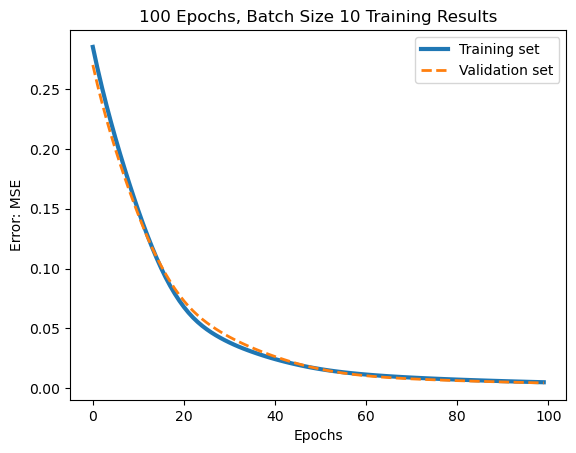

In [75]:
plt.plot(history, label='Training set', linewidth=3)
plt.plot(val_history, label='Validation set', linestyle='dashed', linewidth=2)
plt.title('100 Epochs, Batch Size 10 Training Results')
plt.xlabel('Epochs')
plt.ylabel('Error: MSE')
plt.legend()
plt.show()

Good convergence of error over the 100 epochs for both training and validation sets, without noticeable increase in error. Promising look for testing against overfitting! Let's also take a look at the effectiveness of the trained model against the test data.

### 8. Test best model against test data
We'll test the best model the test data points and record results.

In [43]:
test_history = []
model.eval()
with torch.no_grad():
    for i in range(len(y_test_split)):
        X_sample = X_test_split[i: i+1]
        X_sample = torch.tensor(X_sample.values, dtype=torch.float32)
        y_pred = model(X_sample)
        
        # save error to history
        mse = float(loss_fn(y_pred, y_test_tensor[i]))
        # save to history
        test_history.append(mse)        

In [44]:
# test history average results
avg_mse = np.mean(test_history)
print("MSE: %.5f" % avg_mse)
print("RMSE: %.5f" % np.sqrt(avg_mse))
print('Best MSE: %.5f' % min(test_history))

MSE: 0.00805
RMSE: 0.08974
Best MSE: 0.00004


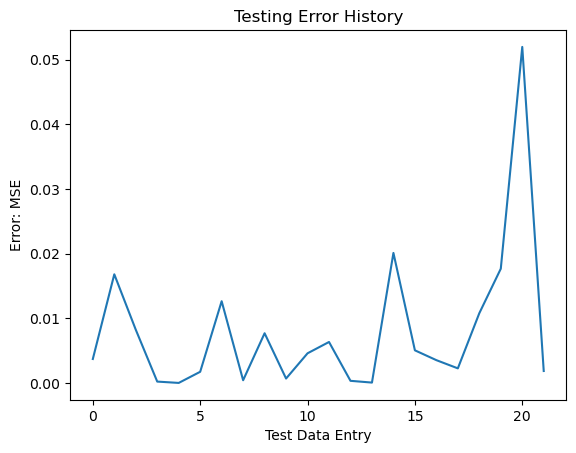

In [45]:
plt.plot(test_history)
plt.title('Testing Error History')
plt.xlabel('Test Data Entry')
plt.ylabel('Error: MSE')
plt.show()

A relative spike is noticed at entry 20 of the test data, perhaps showing that the model performs not as well for data similar to that entry.

### 9. Again, but with a more specific NN structure
The first try was a very basic structure, not necessarily fit for our features/data. Let's see if we can build a better structure and test it out as well. We will follow the same steps, so it will be a bit more condensed this time.

The new structure will add Dropout layers (20%) for the hidden layers, as well as alter the net dimensions to better fit typical net structures. We'll also try using the AdamW optimizer from torch.optim instead of classic Adam. 

In [46]:
from torch.optim import AdamW

In [47]:
# Define PyTorch model, with dropout at hidden layers
class PharmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 128)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

In [76]:
# Helper function to train the model and return the error results, best weights, and history
def model_train(model, X_train, y_train, X_test, y_test,
                n_epochs, batch_size):
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    batch_start = torch.arange(0, len(X_train), batch_size)

    # containers to save results
    best_mse = np.inf
    best_weights = None
    best_epoch = 0 # use this for early stopping
    patience = 5 # early stopping threshold
    history = []
    val_history = []
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit='batch', disable=True, mininterval=0) as bar:
            bar.set_description(f'Epoch {epoch}')
        
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                bar.set_postfix(mse=float(loss))

            model.eval()
            y_pred = model(X_train)
            y_pred_val = model(X_test)
            mse = float(loss_fn(y_pred, y_train))
            mse_val = float(loss_fn(y_pred_val, y_test))
            # save to history
            history.append(mse)
            val_history.append(mse_val)
            # record best mse
            if mse < best_mse:
                best_mse = mse
                best_weights = copy.deepcopy(model.state_dict()) # saves info on best result to load later
                best_epoch = epoch
            elif epoch-best_epoch>patience:
                print("Early stopped training at epoch %d" % epoch)
                break # stop the training loop if it is not improving anymore
                    
    return best_weights, history, best_mse, val_history
        

### 10. Testing the new network with batch_size of 4, 8, 16, 32
Now that we've recreated the structure, let's test again with different batch sizes to find the optimal results.

In [78]:
# Create model, train, test  
# batch_size=4
model = PharmModel()
best_weights, history, best_mse, val_history = model_train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 300, 4)

Early stopped training at epoch 206


In [83]:
#batch_size=8
model1 = PharmModel()
best_weights1, history1, best_mse1, val_history1 = model_train(model1, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 500, 8)

Early stopped training at epoch 312


In [84]:
#batch_size=16
model2 = PharmModel()
best_weights2, history2, best_mse2, val_history2 = model_train(model2, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 500, 16)

Early stopped training at epoch 488


In [85]:
#batch_size=32
model3 = PharmModel()
best_weights3, history3, best_mse3, val_history3 = model_train(model3, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 500, 32)

Early stopped training at epoch 456


In [86]:
# display mse for each batch_size and pick best one
#4
print("Batch_size=4 MSE: %.5f" % best_mse)

#8
print("Batch_size=8 MSE: %.5f" % best_mse1)

#16
print("Batch_size=16 MSE: %.5f" % best_mse2)

#32
print("Batch_size=32 MSE: %.5f" % best_mse3)

Batch_size=4 MSE: 0.00089
Batch_size=8 MSE: 0.00075
Batch_size=16 MSE: 0.00069
Batch_size=32 MSE: 0.00129


As shown above, the best results come from the batch_size of 16, with 500 training epochs, early stopped at 488. Increasing to 32 for the batch size yields worse results.

Best MSE (batch_size=4): 0.00069
Best RMSE (batch_size=4): 0.02622


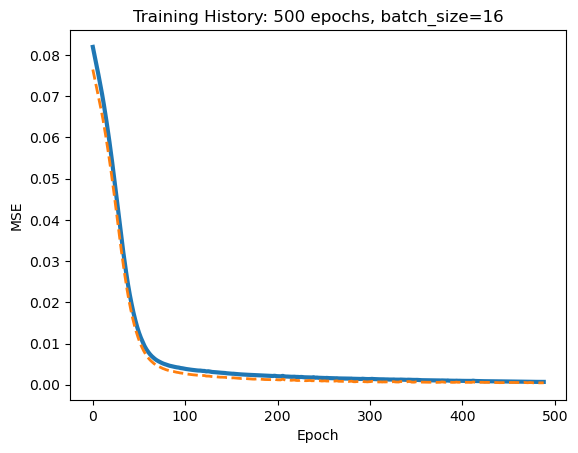

In [87]:
model.load_state_dict(best_weights2)
print("Best MSE (batch_size=16): %.5f" % best_mse2)
print("Best RMSE (batch_size=16): %.5f" % np.sqrt(best_mse2))

# show training history
plt.plot(history2, label='Training set', linewidth=3)
plt.plot(val_history2, label='Validation set', linestyle='dashed', linewidth=2)
plt.title('Training History: 500 epochs, batch_size=16')
plt.xlabel('Epoch')
plt.ylabel('MSE');

**Small note**: Decreasing threshold size to 0 does result in early stopping in batch_size=4, 8. However, increasing the threshold to 2 allows both batch sizes to train to completion.

### 11. Finding error using test set values
Now that we've trained using the training set and evaluated using the validation set, let's also see how the test data fares.

In [88]:
test_history = []
model.eval()
with torch.no_grad():
    for i in range(len(y_test_split)):
        X_sample = X_test_split[i: i+1]
        X_sample = torch.tensor(X_sample.values, dtype=torch.float32)
        y_pred = model(X_sample)
        
        # save error to history
        mse = float(loss_fn(y_pred, y_test_tensor[i]))
        # save to history
        test_history.append(mse)     

MSE: 0.00122
RMSE: 0.03493
Best MSE: 0.00003


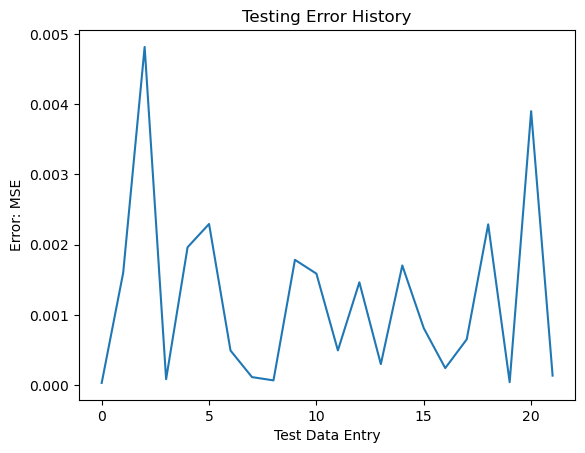

In [89]:
# test history average results
avg_mse = np.mean(test_history)
print("MSE: %.5f" % avg_mse)
print("RMSE: %.5f" % np.sqrt(avg_mse))
print('Best MSE: %.5f' % min(test_history))

plt.plot(test_history)
plt.title('Testing Error History')
plt.xlabel('Test Data Entry')
plt.ylabel('Error: MSE')
plt.show()

There are seemingly more spikes than previously, but it's important to note that the overall error values have come down (by a scale of 10!). The test entry 20 value is also no longer acting as erroneously. Perhaps previous models were slightly overfit!

### 12. Modified Net Takeaways
Modifying the model structure improved performance and resulted in a significantly smaller error value. The final parameters used for this were:

- Structure: Linear(10,128) - ReLU() - Dropout(0.2) - Linear(128,128) - ReLU() - Dropout(0.2) - Linear(128,1)
- Epochs=500
- Batch_size=16
- Loss=MSE
- Optimizer=AdamW
- Early stopping enabled, patience=5

MSE: 0.00122
<br>RMSE: 0.03493

## Pytorch NN Results:
We only explored briefly with this neural net model, but the results are as follows:
1. The main takeaway is that performance was not as strong as previous models: __Basic structure 100 epochs/batch_size=10 resulted in a RMSE of ~0.09; Modified structure 500 epochs/batch_size=16 resulted in a RMSE of ~0.03.__
2. Results are not fully reproduceable despite setting random seeds throughout the project. However, it can be assumed (and tested to show) that results are still within relative similarity to each other, so these results can still be considered when choosing the final model for this problem. The error from using neural nets is still significantly larger than other models (by upwards of a scale of 10x).
3. Increasing epochs does improve performance (to a certain amount), but is still outperformed by previous models on average.
4. Other NN model designs can be used, varying the number of layers, neurons per layer, and even layer types. This was explored by adding Dropout layers and changing the Linear layer structures. This does improve performance, but again is not clearly better than previous models.

Overall, it seems that other models may be better suited to this problem than neural networks.

## Additional Methods: Boosting
We will also explore boosting models to again compare performance. I will introduce two popular boosting algorithms: CatBoost and LightGBM.

### Dependencies and train/test data
Import dependencies. Also, since we converted training and test data to tensor form previously, we need the original data back again. 

In [22]:
# dependencies 
import catboost as cb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [18]:
# redefine training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=seed_value)

### 1. CatBoost
Let's initialize and tune a CatBoost regressor model and measure its performance in comparison to previous models. Again, there is potential for further optimization.

In [20]:
# hyperparameter grid using common hyperparameters and values
grid = {
    'iterations': [100, 150, 200],
    'learning_rate': [0.03, 0.1, 1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

In [57]:
# initialize model
model = CatBoostRegressor(loss_function='RMSE', verbose=False, random_state=seed_value) # RMSE for performance metric

In [1]:
# grid_search for hyperparam tuning
train_data = cb.Pool(X_train, y_train) # combine X and y train for gridsearch
model.grid_search(grid, train_data, verbose=False);

In [59]:
model.get_params()

{'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 42,
 'depth': 2,
 'iterations': 100,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.5}

Let's try on the training and test data and evaluate performance.

In [60]:
# train, test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
# performance RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (CatBoost): ', mse)
print('RMSE (CatBoost): ', rmse)

MSE (CatBoost):  0.0005136280686426054
RMSE (CatBoost):  0.022663364018666896


The result is similar (a little better, but seeding could easily sway this either way) to the result of the tuned random forest, but is still less effective than the untuned, feature dropped random forest from before!

### 2. LightGBM
Similarly, we will also train a LightGBM model to compare performance. Since we used grid_search in CatBoost, we'll also use it for LightGBM (for consistency's sake). Unfortunately, it is not built in like with CatBoost.

In [62]:
# hyperparamter grid
grid = {
    'learning_rate': [0.03, 0.1, 1],
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150],
    'num_leaves' : [60, 80, 100, 120] #should be less than 2^max_depth 
}

In [63]:
# initialize estimator **This is a regression problem
estimator = LGBMRegressor(objective='regression', random_state=seed_value)

In [64]:
# Grid Search
model = GridSearchCV(estimator=estimator, 
                    param_grid=grid,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error')
model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1, 1],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [60, 80, 100, 120]},
             scoring='neg_root_mean_squared_error')

In [69]:
# report best parameters
print(model.best_estimator_)
print(model.best_score_)

LGBMRegressor(max_depth=2, n_estimators=150, num_leaves=60,
              objective='regression', random_state=42)
-0.030814209996924042


Now, we'll just try it again with these parameters and record results!

In [70]:
# new lightGBM model with hyperparameters
model = LGBMRegressor(objective='regression', random_state=seed_value, max_depth=2, n_estimators=150, num_leaves=60)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [71]:
# performance RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (LightGBM): ', mse)
print('RMSE (LightGBM): ', rmse)

MSE (LightGBM):  0.0007596003260214676
RMSE (LightGBM):  0.027560847701430875


Again, a comparable result with CatBoost. It seems that boosting algorithms perform decently well, showing better performance than voting ensemble. However, the feature dropped random forest and voting ensemble are significantly better performing than others as of now. Keep in mind that CatBoost and LightGBM are based on DecisionTree logic, so a setup geared toward RandomForest performance could be suboptimal for these methods.

# Compiliation of Results so Far

The results of modeling are as shown below. Keep in mind that the 'all features' and 'seoul_2 only' modeling have extremely low error results due to the non-independent nature of the 'Seoul_2' feature. 

Furthermore, error values will vary slightly between executions due to variance in training optimizations, especially for the neural net. The random seed has been set and implemented since the beginning of the project.

The best model results are **in bold**; the next best results are <u>underlined</u>.

<div>
<img src="Data/model_results.PNG" width=1000/>
</div>

# Modeling Conclusion
After trying several different models and algorithms, we have come to the conclusion that the best choice for this problem, predicting the total pharmaceutical drug sales in South Korea, is to use a Random Forest following feature elimination. Though the ensembling techniques also performed very similarly, the goal of this project is not necessarily to find the extreme, most optimal solution for this problem, and is instead aiming to work through the entire production process of researching, developing, and building a ML model to deployment.

Thus, using these results, we will move on to deployment of this final model. This will be done in the /Pharm_Deploy folder, where the goal is to create a Flask REST API with this model as a script, build a container using Docker, and deploying it to the web using Amazon Web Servies. The process can be seen below: 

<div>
<img src="Data/deployment_solution_architechture.jpg" width=1000/>
</div>

The Pharm_Deploy folder will detail the entire process of deploying this modeling solution to the web, and will also give instructions on recreating or modifying this process for new data!